In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))

In [ ]:
from fit.lib import *

c = np.array([[0,2.5],[2,5+10]])

ModuleNotFoundError: No module named 'BEACH'

In [3]:
import pandas as pd
df = pd.DataFrame(c, columns=['j', 'coef'])
df.to_csv('coef_file.csv', index=False)

In [4]:
df = pd.read_csv('coef_file.csv')
df

,j,coef
0,0.0,2.5
1,2.0,15.0


In [14]:
x,y = np.linspace(-50,50,100), np.linspace(-50,50,100)
Gen = GenBeam(1000,x,y,df['coef'].values)
z= Gen.basis_j((2,2))

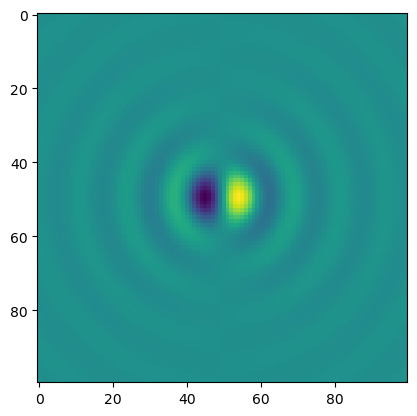

In [15]:
plt.imshow(z[1,:].reshape(100,100))

In [8]:
g = twoD_Gaussian(x,y,1,7,10,1,0,45,0)

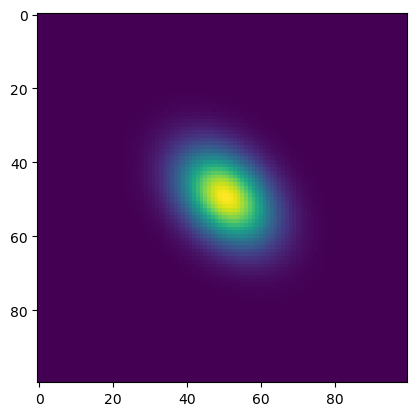

In [9]:
plt.imshow(g)

/var/folders/25/jcpftdwn4dz92_1tq7g2cdw40000gn/T/ipykernel_21891/177742212.py:22: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y.append(np.real(sph_harm(m, l, phi_grid, theta_grid)).flatten())
/var/folders/25/jcpftdwn4dz92_1tq7g2cdw40000gn/T/ipykernel_21891/177742212.py:23: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y.append(np.imag(sph_harm(m, l, phi_grid, theta_grid)).flatten())


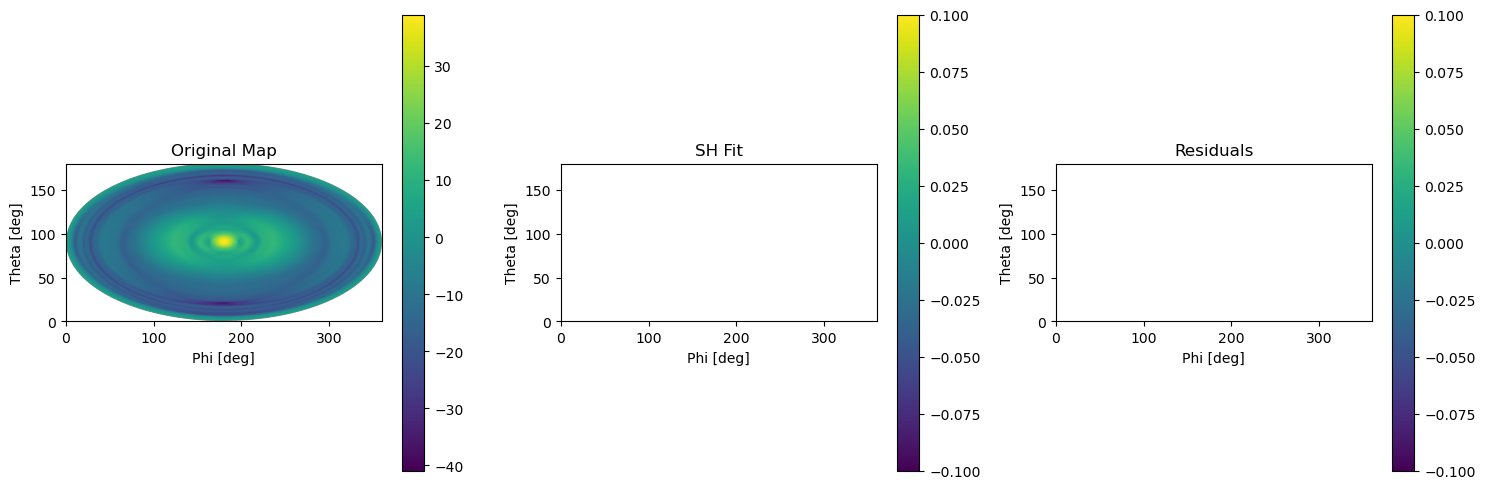

In [ ]:
plt.imshow(g-z[1,:].reshape(100,100))

In [4]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
beam = np.load("../test_beam_2.1deg.npy")
# -----------------------
# 1. Create 2D Cartesian grid
# -----------------------
n_theta, n_phi = 1000, 1000
theta = np.linspace(0, np.pi, n_theta)       # colatitude
phi = np.linspace(0, 2*np.pi, n_phi)         # longitude
theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')

# Example map: function of theta and phi
map_2d = beam #np.sin(theta_grid) * np.cos(phi_grid)  # replace with your actual map

# -----------------------
# 2. Interpolate to HEALPix
# -----------------------
nside = 128
npix = hp.nside2npix(nside)

# HEALPix pixel angles
theta_pix, phi_pix = hp.pix2ang(nside, np.arange(npix))

# Interpolator
interp = RegularGridInterpolator(
    (theta, phi), map_2d, bounds_error=False, fill_value=0.0
)

# Interpolate Cartesian grid to HEALPix pixels
healpix_map = interp(np.stack([theta_pix, phi_pix], axis=-1))

# -----------------------
# 3. Plot comparison
# -----------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Original 2D grid
im0 = axs[0].imshow(map_2d, origin='lower', extent=[0, 360, 0, 180])
axs[0].set_title('Original Cartesian Grid')
axs[0].set_xlabel('Phi [deg]')
axs[0].set_ylabel('Theta [deg]')
plt.colorbar(im0, ax=axs[0])

# HEALPix map (Mollweide)
hp.mollview(healpix_map, title='HEALPix Map', sub=(1,2,2), rot=(180,0))
hp.graticule()

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../test_beam_2.1deg.npy'

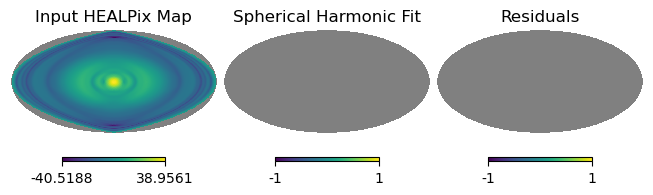

In [10]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

nside = 128
lmax_fit = 10   # choose maximum multipole for fit
alm = hp.map2alm(healpix_map, lmax=lmax_fit)    # spherical harmonic coefficients
fit_map = hp.alm2map(alm, nside, lmax=lmax_fit) # reconstructed map
residual_map = healpix_map - fit_map

# -----------------------
# 4. Plots
# -----------------------
hp.mollview(healpix_map, title="Input HEALPix Map", sub=(1,3,1), rot=(180,0))
hp.mollview(fit_map, title="Spherical Harmonic Fit", sub=(1,3,2), rot=(180,0))
hp.mollview(residual_map, title="Residuals", sub=(1,3,3), rot=(180,0))
#hp.graticule()

plt.show()


In [ ]:
#fitting test beam with Zernike polynomials

from fit.lib import *

x,y = np.linspace(-50,50,100), np.linspace(-50,50,100)


In [2]:
import numpy as np
beam = np.load("../BEACH/beams_cart_perturbed_fiducial.npz")  

In [3]:
beam.keys

<bound method NpzFile.keys of NpzFile '../BEACH/beams_cart_perturbed_fiducial.npz' with keys: x, y, freq, beam1, beam2>

In [4]:
ini =[1.0, 1.0, 1.0,0,0,0]
init = np.array(ini)
init.shape

(6,)

In [3]:

import numpy as np
from skimage.transform import resize

# Load the cube
data = np.load("beams_cart_perturbed_fiducial.npz")["beam2"]  # assumes stored with key 'cube'
x = np.load("beams_cart_perturbed_fiducial.npz")["x"]
y = np.load("beams_cart_perturbed_fiducial.npz")["y"]
freq = np.load("beams_cart_perturbed_fiducial.npz")["freq"]


# Define downsampling factor
factor = 4  # e.g., reduce each dimension by half

# Prepare output array
nz, ny, nx = data.shape
new_ny, new_nx = ny // factor, nx // factor
downsampled_cube = np.zeros((nz, new_ny, new_nx))

# Downsample each slice
for i in range(nz):
    downsampled_cube[i] = resize(
        data[i], (new_ny, new_nx), anti_aliasing=True, preserve_range=True
    )


# Downsample coordinates (keep same range but fewer points)
x_new = np.linspace(x.min(), x.max(), new_nx)
y_new = np.linspace(y.min(), y.max(), new_ny)

# Save back to .npz
np.savez("downsampled_cube.npz", fiducial=downsampled_cube, x=x_new, y=y_new, freq=freq)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
d = np.load("/Users/ajithsampath/SwissPostdoc/downsampled_cube.npz")

In [11]:
d.keys()

KeysView(NpzFile '/Users/ajithsampath/SwissPostdoc/downsampled_cube.npz' with keys: fiducial, x, y, freq)

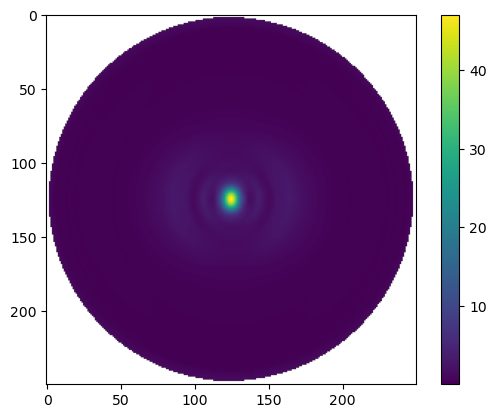

In [13]:
plt.imshow(np.e**(d['fiducial'][0]))
plt.colorbar()

In [2]:
#downsampling beam to desired size

import numpy as np
from skimage.transform import resize

# Load the cube
data = np.load("/Users/ajithsampath/SwissPostdoc/beams_cart_perturbed_fiducial.npz")["beam2"]  # assumes stored with key 'cube'
x = np.load("/Users/ajithsampath/SwissPostdoc/beams_cart_perturbed_fiducial.npz")["x"]
y = np.load("/Users/ajithsampath/SwissPostdoc/beams_cart_perturbed_fiducial.npz")["y"]
freq = np.load("/Users/ajithsampath/SwissPostdoc/beams_cart_perturbed_fiducial.npz")["freq"]


new_shape = (64, 256, 256)

# Downsample (preserving data range)
downsampled = resize(data, new_shape, anti_aliasing=True, preserve_range=True)

print(downsampled.shape)

(64, 256, 256)


In [3]:
x = np.linspace(x.min(),x.max(),256)
y = np.linspace(y.min(),y.max(),256)

In [4]:
freq = np.linspace(freq.min(),freq.max(),64)

In [5]:
freq.shape

(64,)

In [6]:
import numpy as np

def crop_by_radius(arr, x, y, center, radius):

    x0, y0 = center
    X, Y = np.meshgrid(x, y)
    R = np.sqrt((X - x0)**2 + (Y - y0)**2)
    mask = R <= radius
    return arr * mask


In [10]:
cropped = crop_by_radius(downsampled[0], x, y, center=(0, 0), radius=75.0)


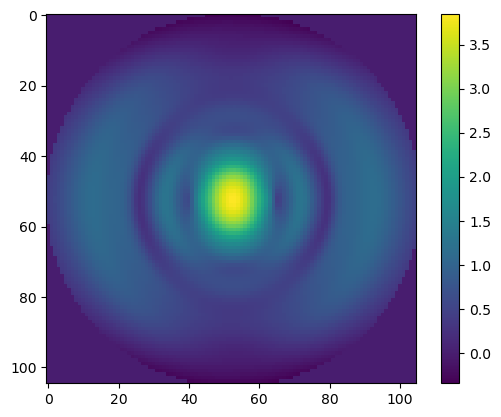

In [23]:
import matplotlib.pyplot as plt
plt.imshow(cropped[75:180,75:180])
plt.colorbar()

In [ ]:

np.savez("samplecube.npz",x=x,y=y,freq=freq,data=10**downsampled)

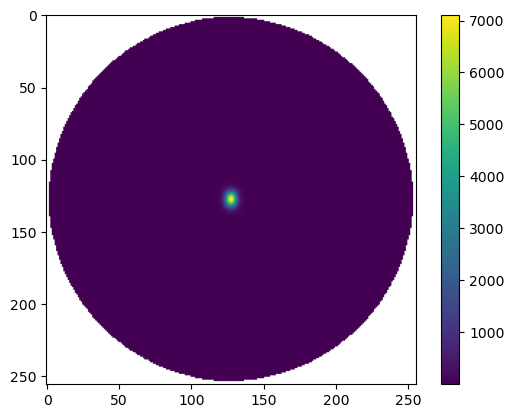

In [5]:
plt.imshow(10**downsampled[0])
plt.colorbar()

In [6]:
data = 10**downsampled

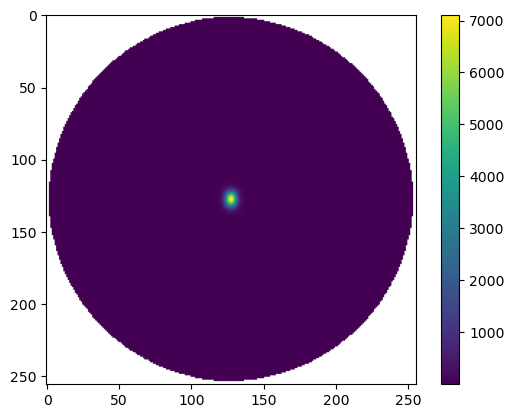

In [7]:
plt.imshow(data[0])
plt.colorbar()

In [8]:
import numpy as np
x = np.random.rand(50,256,256)
print("Success:", x.nbytes/1e6, "MB allocated")

Success: 26.2144 MB allocated


In [24]:
data = np.load("/Users/ajithsampath/SwissPostdoc/samplecube.npz")["data"]  # assumes stored with key 'cube'
x = np.load("/Users/ajithsampath/SwissPostdoc/samplecube.npz")["x"]
y = np.load("/Users/ajithsampath/SwissPostdoc/samplecube.npz")["y"]
freq = np.load("/Users/ajithsampath/SwissPostdoc/samplecube.npz")["freq"]

In [25]:
x.shape

(256,)

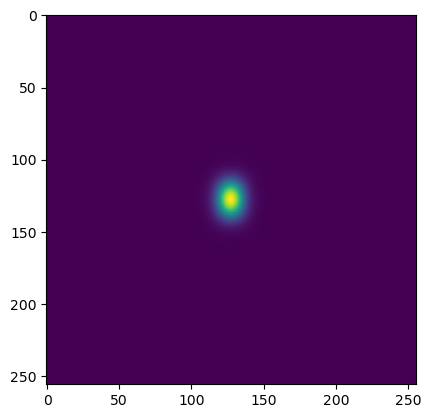

In [26]:
plt.imshow(data[0])

In [4]:
import numpy as np
import pandas as pd
def NollToQuantum(j):
    # Ensure j is a numpy array
    
    n = int(np.ceil((-3 + np.sqrt(9 + 8 * j)) / 2))
    m = int((2 * j) - n * (n + 2))
    return n, m;

def reorder_coef(coef):
    
    neg_m_list = []
    for j in range(coef.shape[0]):
        [n,m]=NollToQuantum(j)
        if m<0:
            neg_m_list.append(j)
    for g in neg_m_list:
        coef=np.delete(coef, -1)
        coef=np.insert(coef,g,0.0)
    return coef;


coef = np.loadtxt('../outputs/Coef_full.csv')
coef = reorder_coef(coef)

j = np.arange(len(coef))

vectorized_NollToQuantum = np.vectorize(NollToQuantum)

n_val,m_val = vectorized_NollToQuantum(j)

coef_jnm = np.column_stack((j,n_val,m_val,coef))

df_coef = pd.DataFrame(coef_jnm, columns=['j','n','m','coef'])

df_coef.to_csv('coef_test2.csv', index=False)

In [43]:
coef

array([ 2.0940151 , -0.03123356, -0.72084958, ...,  0.        ,
        0.        ,  0.        ])

In [8]:

# Extract the 4th column (index 3) for coefficient selection
coefs = df_coef.iloc[:, 3].values

# Sort indices by absolute value of 4th column, descending
sorted_indices = np.argsort(np.abs(coefs))[::-1]

# Calculate cumulative contribution ratio on sorted 4th column
sorted_coefs = coefs[sorted_indices]
cumulative_contrib = np.cumsum(np.abs(sorted_coefs)) / np.sum(np.abs(sorted_coefs))

# Find how many coefficients to keep for 99% contribution
num_coefs = np.searchsorted(cumulative_contrib, 0.99) + 1

# Select indices of top coefficients
selected_indices = sorted_indices[:num_coefs]

# Select corresponding rows from original dataframe, preserving all columns
selected_df = df_coef.iloc[selected_indices]
selected_df = selected_df.sort_index()
print(selected_df)

           j     n     m      coef
0        0.0   0.0   0.0  2.094015
4        4.0   2.0   0.0 -0.720850
144    144.0  16.0   0.0  0.937308
145    145.0  16.0   2.0 -0.716609
180    180.0  18.0   0.0  2.071570
...      ...   ...   ...       ...
1473  1473.0  53.0  31.0 -0.717403
1474  1474.0  53.0  33.0 -0.899109
1475  1475.0  53.0  35.0  0.981227
1476  1476.0  53.0  37.0 -1.289797
1477  1477.0  53.0  39.0  0.700865

[376 rows x 4 columns]


In [19]:
import numpy as np

def NollToQuantum(j):
    # Ensure j is a numpy array
    
    n = int(np.ceil((-3 + np.sqrt(9 + 8 * j)) / 2))
    m = int((2 * j) - n * (n + 2))
    return n, m;

vectorized_NollToQuantum = np.vectorize(NollToQuantum)

n_val,m_val = vectorized_NollToQuantum(j)

In [ ]:
Quant_idx = np.array[]

(2, 502)

array([  0,  -1,   1,  -2,   0,   2,  -3,  -1,   1,   3,  -4,  -2,   0,
         2,   4,  -5,  -3,  -1,   1,   3,   5,  -6,  -4,  -2,   0,   2,
         4,   6,  -7,  -5,  -3,  -1,   1,   3,   5,   7,  -8,  -6,  -4,
        -2,   0,   2,   4,   6,   8,  -9,  -7,  -5,  -3,  -1,   1,   3,
         5,   7,   9, -10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,
        10, -11,  -9,  -7,  -5,  -3,  -1,   1,   3,   5,   7,   9,  11,
       -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10,  12,
       -13, -11,  -9,  -7,  -5,  -3,  -1,   1,   3,   5,   7,   9,  11,
        13, -14, -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,
        10,  12,  14, -15, -13, -11,  -9,  -7,  -5,  -3,  -1,   1,   3,
         5,   7,   9,  11,  13,  15, -16, -14, -12, -10,  -8,  -6,  -4,
        -2,   0,   2,   4,   6,   8,  10,  12,  14,  16, -17, -15, -13,
       -11,  -9,  -7,  -5,  -3,  -1,   1,   3,   5,   7,   9,  11,  13,
        15,  17, -18, -16, -14, -12, -10,  -8,  -6,  -4,  -2,   